### Details

`/raw/DocLayNet_core.zip` downloaded from [DocLayNet_core.zip dataset](https://codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud/dax-doclaynet/1.0.0/DocLayNet_core.zip)

`/raw/RVL-CDIP-invoice.zip` downloaded from [chainyo/rvl-cdip-invoice](https://huggingface.co/datasets/chainyo/rvl-cdip-invoice). It can also be downloaded from [aharley/rvl_cdip](https://huggingface.co/datasets/aharley/rvl_cdip).

`/processed/vectors/RVL-CDIP-invoice.json.zip` generated using `/raw/RVL-CDIP-invoice.zip`, and the model to create the following features.

### Preview Data Raw

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!GIT_LFS_SKIP_SMUDGE=1 git clone --depth=1 https://huggingface.co/spaces/mckabue/document-similarity-search-using-visual-layout-features

Mounted at /content/drive
Cloning into 'document-similarity-search-using-visual-layout-features'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 166 (delta 4), reused 154 (delta 4), pack-reused 0
Receiving objects: 100% (166/166), 2.72 MiB | 3.15 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Error reading git config: error running /usr/lib/git-core/git 'config' '--includes' '-l' '-f' '/content/document-similarity-search-using-visual-layout-features/.lfsconfig': 'fatal: bad config line 4 in file /content/document-similarity-search-using-visual-layout-features/.lfsconfig' 'exit status 128'
Error reading git config: error running /usr/lib/git-core/git 'config' '--includes' '-l' '-f' '/content/document-similarity-search-using-visual-layout-features/.lfsconfig': 'fatal: bad config line 4 in file /content/document-similarity-search-using-visual-layout-features/.lfsconfig' 'exit stat

In [2]:
import sys
sys.path.insert(0, './document-similarity-search-using-visual-layout-features')

%load_ext autoreload
%autoreload 2

DOC_LAY_NET_CORE_ZIP = '/content/drive/MyDrive/Colab Notebooks/detectron2/Training/DocLayNet_core.zip'
RVL_CDIP_invoice = './raw/RVL-CDIP-invoice.zip'

In [3]:
%pip install treeviz
%pip install --quiet simplebbox

  Preparing metadata (setup.py) ... done
  Created wheel for treeviz: filename=treeviz-1.1-py3-none-any.whl size=3318 sha256=ad70e71f266b74b6745485f3f16d4e744da8b83df58ba3fd1e8d62931f9aac53
  Stored in directory: /root/.cache/pip/wheels/c8/10/db/c09faa7144d0b5f0b3f7a691dd7f7a5b42e139f3b35273192c
Successfully built treeviz


In [6]:
import zipfile
import re
from utils.read_zip_file import read_zip_file
import json
from treeviz.treeviz import Node
from utils.visualize_bboxes_on_image import visualize_bboxes_on_image
from PIL import Image
import os
from simplebbox.array import x0y0wh_to_x0y0x1y1
from utils.remove_duplicates import remove_duplicates
from utils.show_tile_images import show_tile_images
import random

#### `/raw/DocLayNet_core.zip` contents

##### Directory structure

In [7]:
doc_lay_zipfile = zipfile.ZipFile(DOC_LAY_NET_CORE_ZIP, 'r')

test_json = json.load(read_zip_file(DOC_LAY_NET_CORE_ZIP, 'COCO/test.json'))
train_json = json.load(read_zip_file(DOC_LAY_NET_CORE_ZIP, 'COCO/train.json'))
val_json = json.load(read_zip_file(DOC_LAY_NET_CORE_ZIP, 'COCO/val.json'))

root = Node("./raw/DocLayNet_core.zip")
child1 = Node("COCO/")
child1.add_child(Node('.DS_Store'))
test_json_node = Node('test.json')
[test_json_node.add_child(Node(f'{key} - {len(values):,} {key}')) for key, values in test_json.items()]
train_json_node = Node('train.json')
[train_json_node.add_child(Node(f'{key} - {len(values):,} {key}')) for key, values in train_json.items()]
val_json_node = Node('val.json')
[val_json_node.add_child(Node(f'{key} - {len(values):,} {key}')) for key, values in val_json.items()]
child1.add_child(test_json_node)
child1.add_child(train_json_node)
child1.add_child(val_json_node)
child2 = Node("PNG/")
images = [i.filename for i in doc_lay_zipfile.filelist if re.fullmatch('PNG/.+\.png', i.filename)]
child2.add_child(Node(f'*.png - {len(images):,} images'))
root.add_child(child1)
root.add_child(child2)
root.visualize(line_space=1)

./raw/DocLayNet_core.zip
├── COCO/
│   │   
│   ├── .DS_Store
│   │       
│   ├── test.json
│   │   │   
│   │   ├── categories - 11 categories
│   │   │       
│   │   ├── images - 4,999 images
│   │   │       
│   │   └── annotations - 66,531 annotations
│   │           
│   ├── train.json
│   │   │   
│   │   ├── categories - 11 categories
│   │   │       
│   │   ├── images - 69,375 images
│   │   │       
│   │   └── annotations - 941,123 annotations
│   │           
│   └── val.json
│       │   
│       ├── categories - 11 categories
│       │       
│       ├── images - 6,489 images
│       │       
│       └── annotations - 99,816 annotations
│               
└── PNG/
    │   
    └── *.png - 81,471 images
            


##### Contents

In [8]:
def get_annotatated_image(coco_json: json, image_path: str):
  categories = [i['name'] for i in coco_json['categories']]
  image_obj= next(i for i in coco_json['images'] if i['file_name'] == image_path)
  image_id = image_obj['id']
  image_path = image_obj['file_name']
  annotations = [i for i in coco_json['annotations'] if i['image_id'] == image_id]
  bboxes = [x0y0wh_to_x0y0x1y1(i['bbox']) for i in annotations]
  labels = [categories[i['category_id']-1] for i in annotations]
  bboxes, labels = remove_duplicates(zip(bboxes, labels), key=lambda x: tuple(x[0]), unzip=True)
  image = Image.open(read_zip_file(DOC_LAY_NET_CORE_ZIP, os.path.join("PNG", image_path))).convert('RGB')
  return visualize_bboxes_on_image(
    image,
    bboxes,
    labels,
    label_text_color='white',
    label_rectangle_color='black',
    label_text_size=14,
    label_text_padding=5,
    label_rectangle_left_margin=0,
    label_rectangle_top_margin=0,)

def format_name(file_name: str):
  name_, ext_ = file_name.split('.')
  return f'PNG/{name_[:4]}---{name_[-4:]}.{ext_}'

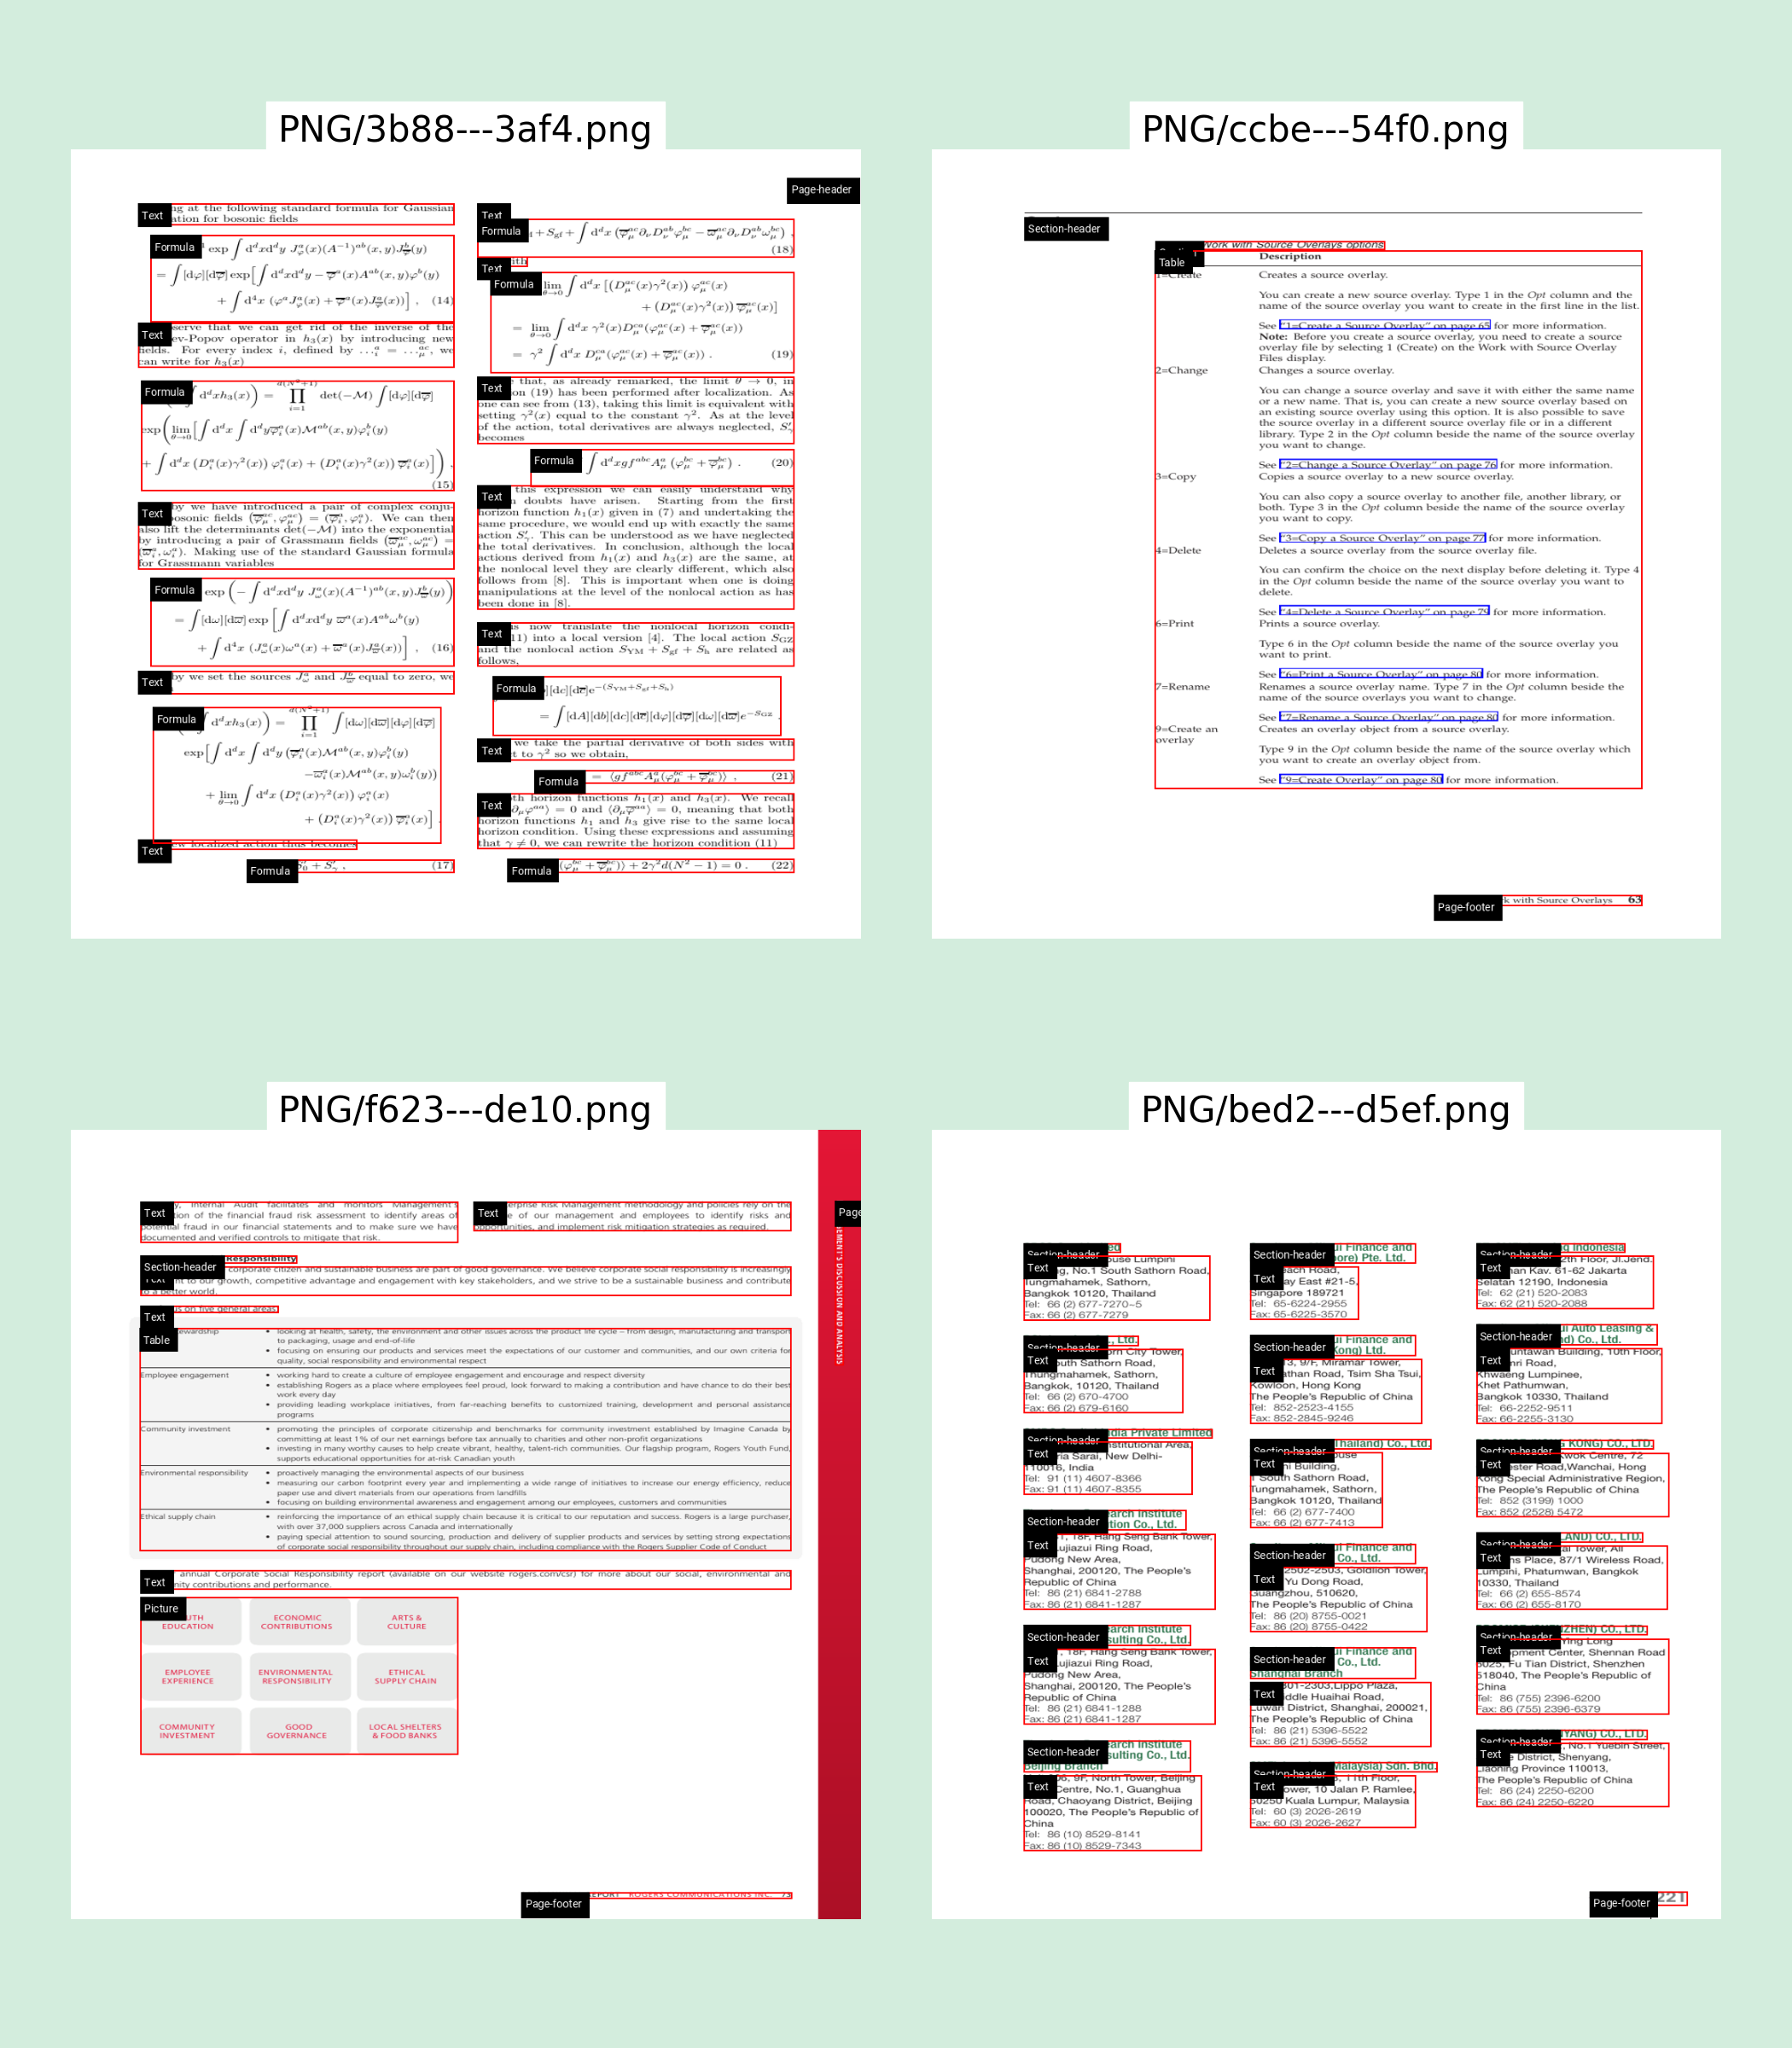

In [16]:
images_sample = random.sample([i['file_name'] for i in test_json['images']], 4)
show_tile_images(
    images = [get_annotatated_image(test_json, i) for i in images_sample],
    titles = [format_name(i) for i in images_sample],
    width_parts = 2,
    figsize = (10.5 * 2, 12 * (len(images_sample) / 2)),
    space = 6,
    pad = True,
    figcolor = '#d3eddd',
    title_color = 'black',
    title_background_color = 'white',
    title_font_size = 30)

In [29]:
def show_one():
  while True:
    [i] = random.sample([i['file_name'] for i in test_json['images']], 1)
    print(i)
    yield get_annotatated_image(test_json, i)
iter = show_one()

eae40317d83ba98d3e70427e6d7baff6dec2bc448538644e0ed6e29ad61d1f59.png


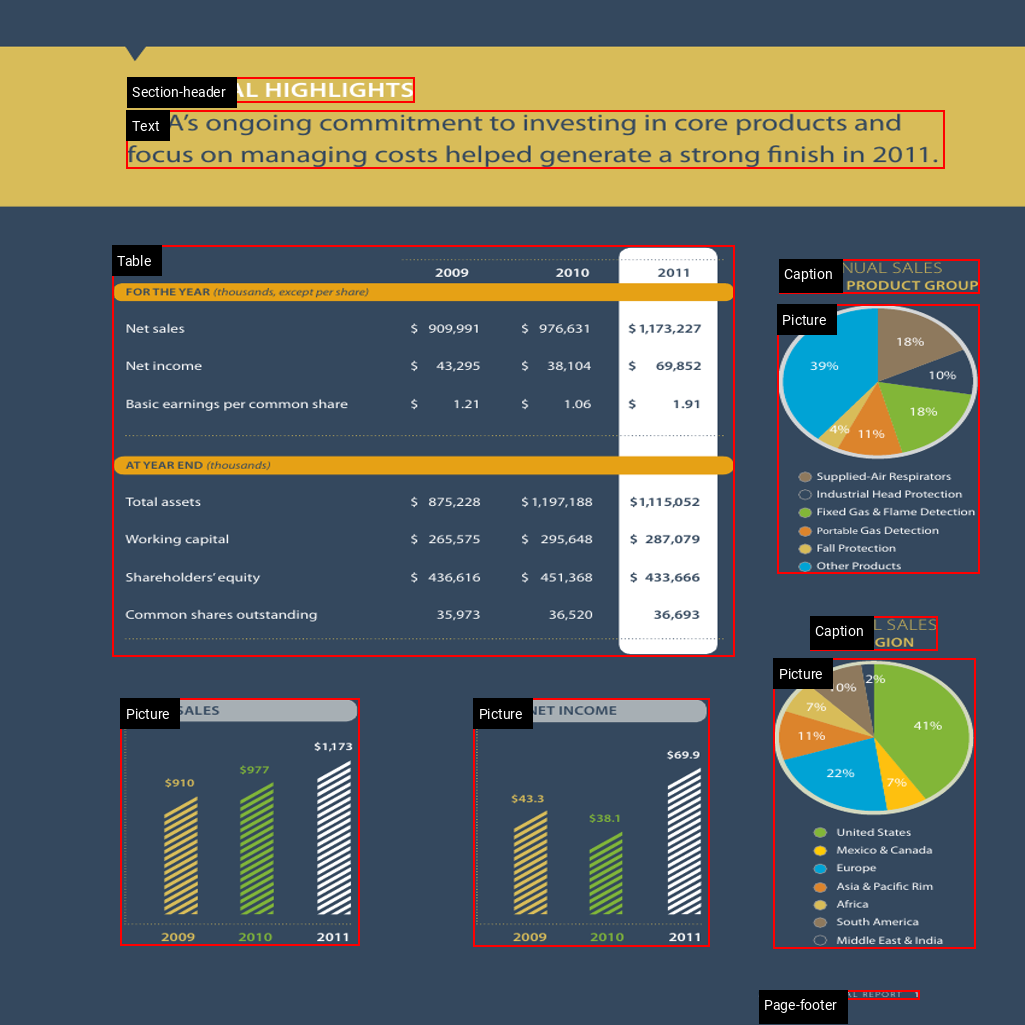

In [82]:
next(iter)

#### `/raw/RVL-CDIP-invoice.zip` contents

##### Directory structure

In [ ]:
invoices_zipfile = zipfile.ZipFile(RVL_CDIP_invoice, 'r')

root_invoices = Node(RVL_CDIP_invoice)

root_invoices_images = Node("RVL-CDIP-invoice/")
invoice_images = [i.filename for i in invoices_zipfile.filelist if re.fullmatch('RVL-CDIP-invoice/.+\.png', i.filename)]
root_invoices_images.add_child(Node(f'*.png - {len(invoice_images):,} images'))
root_invoices.add_child(root_invoices_images)
root_invoices.visualize(line_space=1)

./raw/RVL-CDIP-invoice.zip
└── RVL-CDIP-invoice/
    │   
    └── *.png - 19,947 images
            


##### Contents

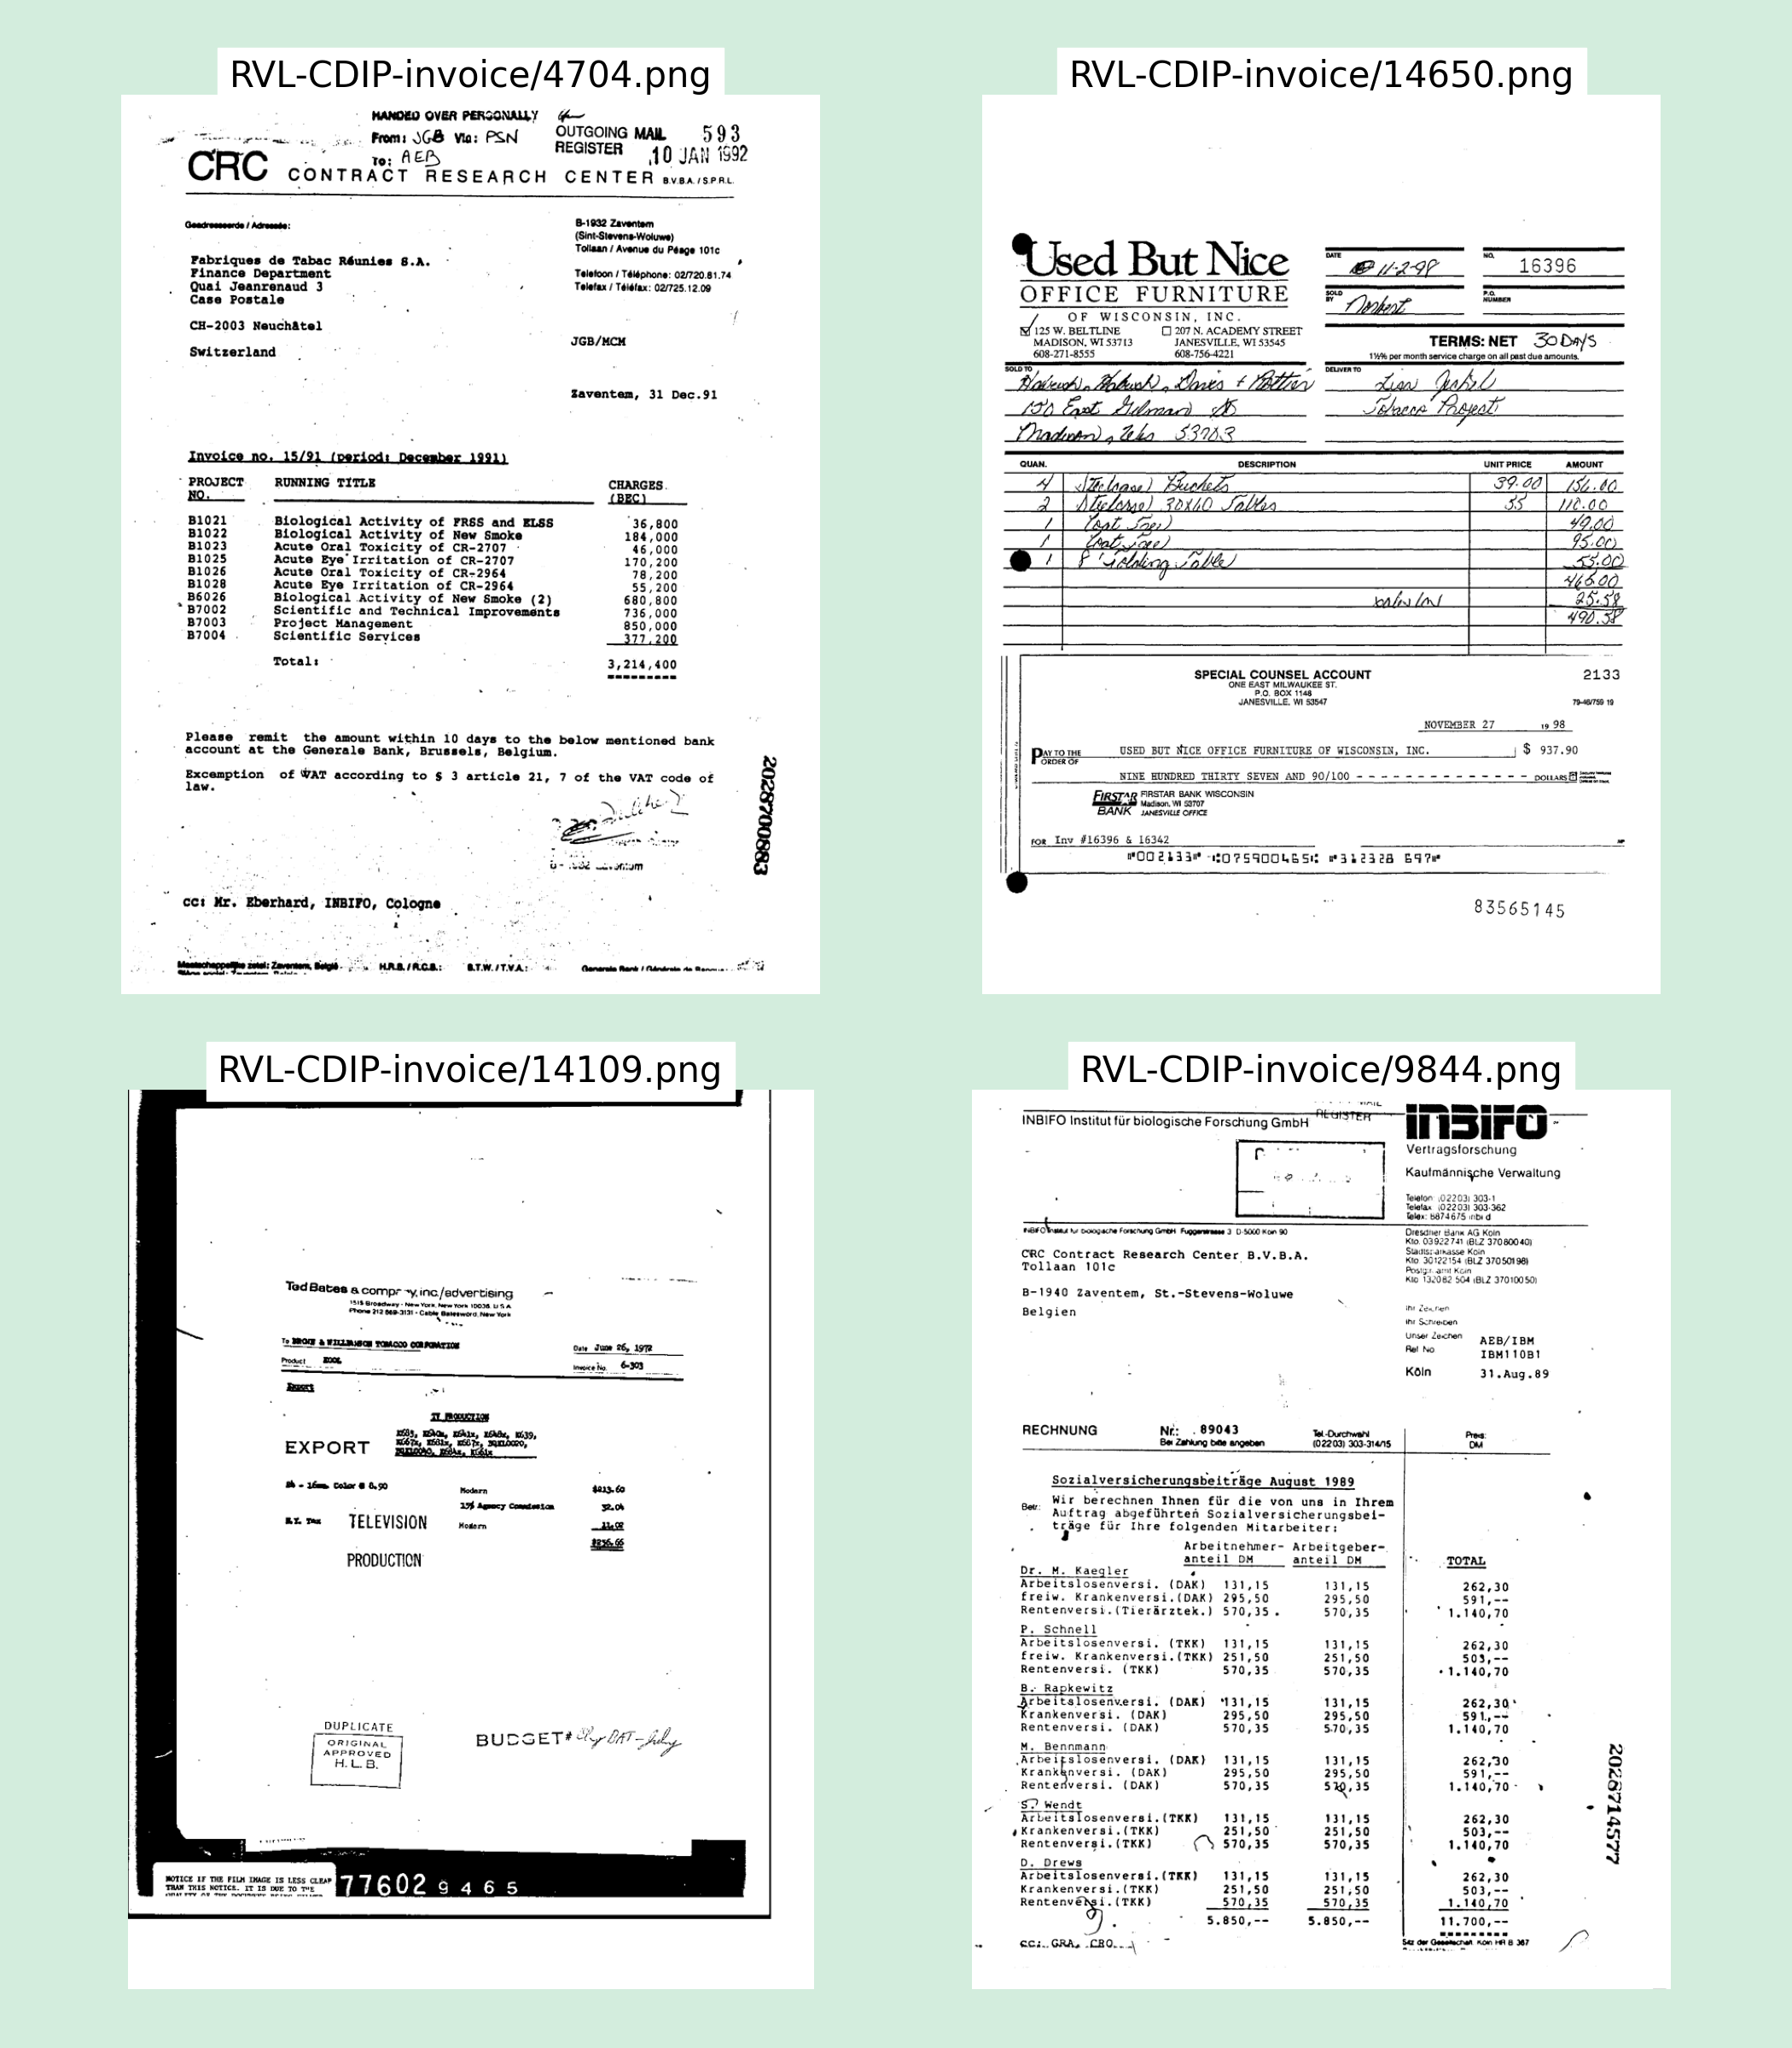

In [ ]:
invoice_images_sample = random.sample(invoice_images, 4)
show_tile_images(
    images = [Image.open(read_zip_file(RVL_CDIP_invoice, i)).convert('RGB') for i in invoice_images_sample],
    titles = [i for i in invoice_images_sample],
    width_parts = 2,
    figsize = (10.5 * 2, 12 * (len(invoice_images_sample) / 2)),
    space = 5,
    pad = True,
    figcolor = '#d3eddd',
    title_color = 'black',
    title_background_color = 'white',
    title_font_size = 30)